In [99]:
import yaml
import pandas as pd 
import matplotlib.pyplot as plt
import anndata as ad
controls = ['negative_control','positive_control']
grn_models = ['collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']

## GRN inference: multiomics

### scGLUE

In [1]:
!aws s3 sync s3://openproblems-data/resources/grn/results/scglue ./resources/results/scglue

download: s3://openproblems-data/resources/grn/results/scglue/state.yaml to resources/results/scglue/state.yaml
download: s3://openproblems-data/resources/grn/results/scglue/trace.txt to resources/results/scglue/trace.txt
download: s3://openproblems-data/resources/grn/results/scglue/output/grn.csv to resources/results/scglue/output/grn.csv


In [3]:
!viash run src/exp_analysis/config.vsh.yaml -- --tf_gene_net resources/results/scglue/output/grn.csv

Reading input files
Calculate basic stats
Outputting stats to : /viash_automount/mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_benchmark/output/stats.json
Topological analysis
Plotting tf-gene in degree, dir:  /viash_automount/mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_benchmark/output/tf_gene_indegree.png
Plotting tf-gene out degree, dir:  /viash_automount/mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_benchmark/output/tf_gene_outdegree.png


## GRN evaluation for multiomics methods

In [1]:
!viash ns build --setup cb -q run_grn_evaluation

temporaryFolder: /tmp/viash_hub_repo10489538114835231235 uri: https://github.com/openproblems-bio/openproblems-v2.git
Cloning into '.'...
checkout out: List(git, checkout, origin/main_build, --, .) 0 
Exporting run_grn_evaluation (workflows) =nextflow=> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_inference/target/nextflow/workflows/run_grn_evaluation
Not all configs built successfully
  39 configs were disabled
  1/1 configs built successfully


In [8]:
!bash scripts/run_grn_evaluation.sh "ridge"


In [9]:
!aws s3 sync s3://openproblems-data/resources/grn/results/grn_evaluation_ridge ./resources/results/grn_evaluation_ridge

download: s3://openproblems-data/resources/grn/results/grn_evaluation_ridge/scores.yaml to resources/results/grn_evaluation_ridge/scores.yaml
download: s3://openproblems-data/resources/grn/results/grn_evaluation_ridge/trace.txt to resources/results/grn_evaluation_ridge/trace.txt
download: s3://openproblems-data/resources/grn/results/grn_evaluation_ridge/metric_configs.yaml to resources/results/grn_evaluation_ridge/metric_configs.yaml


# Robustness analysis

In [1]:
# !viash ns build --setup cb --parallel
!viash ns build --setup cb -q run_robustness_analysis


temporaryFolder: /tmp/viash_hub_repo10268443552668753296 uri: https://github.com/openproblems-bio/openproblems-v2.git
Cloning into '.'...
checkout out: List(git, checkout, origin/main_build, --, .) 0 
Exporting run_robustness_analysis (workflows) =nextflow=> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_inference/target/nextflow/workflows/run_robustness_analysis
Not all configs built successfully
  39 configs were disabled
  1/1 configs built successfully


## Shuffle net

In [3]:
!bash scripts/run_robust_analys.sh "net"

In [7]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_net ./resources/results/robust_analy_reg2_net

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/state.yaml to resources/results/robust_analy_reg2_net/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/scores.yaml to resources/results/robust_analy_reg2_net/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/metric_configs.yaml to resources/results/robust_analy_reg2_net/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/trace.txt to resources/results/robust_analy_reg2_net/trace.txt


## Add noise to weights

In [41]:
!bash scripts/run_robust_analys.sh "weight"

weight
Nextflow 24.04.4 is available - Please consider updating your version to it
N E X T F L O W  ~  version 23.10.4
Launching `target/nextflow/workflows/run_robustness_analysis/main.nf` [dreamy_davinci] DSL2 - revision: 6bd5cda1f4
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (1)
[5f/aa4675] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (6)
[f3/689356] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustn

In [9]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight ./resources/results/robust_analy_reg2_weight

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/scores.yaml to resources/results/robust_analy_reg2_weight/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/state.yaml to resources/results/robust_analy_reg2_weight/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/metric_configs.yaml to resources/results/robust_analy_reg2_weight/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/trace.txt to resources/results/robust_analy_reg2_weight/trace.txt


## Negative vs positive controls

In [8]:
!bash scripts/run_pc_vs_nc.sh "pc_vs_nc"

In [12]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_pc_vs_nc ./resources/results/robust_analy_reg2_pc_vs_nc

## regulatory sign

In [50]:
!bash scripts/run_robust_analys.sh "sign"

sign
Nextflow 24.04.4 is available - Please consider updating your version to it
N E X T F L O W  ~  version 23.10.4
Launching `target/nextflow/workflows/run_robustness_analysis/main.nf` [soggy_sinoussi] DSL2 - revision: d55e1b9116
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (2)
[2f/3f5479] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (6)
[f9/652d7d] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustne

In [10]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign ./resources/results/robust_analy_reg2_sign

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/trace.txt to resources/results/robust_analy_reg2_sign/trace.txt
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/state.yaml to resources/results/robust_analy_reg2_sign/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/scores.yaml to resources/results/robust_analy_reg2_sign/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/metric_configs.yaml to resources/results/robust_analy_reg2_sign/metric_configs.yaml


## Corr vs causal

In [ ]:
!bash scripts/run_robust_analys_causal.sh 

In [4]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_causal_1 ./resources/results/robust_analy_causal_1

download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/scores.yaml to resources/results/robust_analy_causal_1/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/state.yaml to resources/results/robust_analy_causal_1/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/trace.txt to resources/results/robust_analy_causal_1/trace.txt
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/metric_configs.yaml to resources/results/robust_analy_causal_1/metric_configs.yaml


reg1-corr-5
reg1-corr-3
reg1-corr-2
reg1-corr-10
reg1-corr-1
reg1-corr-9
reg1-corr-8
reg1-corr-6
reg1-corr-7
reg1-corr-4


,ex(False)_tf(-1),ex(True)_tf(-1),Mean
corr_5,0.160433,0.168758,0.164596
corr_3,0.191852,0.202196,0.197024
corr_2,0.202665,0.213507,0.208086
corr_10,0.166490,0.175233,0.170861
corr_1,0.222673,0.234688,0.228680
corr_9,0.182540,0.192268,0.187404
corr_8,0.186710,0.196692,0.191701
corr_6,0.217203,0.229086,0.223144
corr_7,0.238084,0.250973,0.244528
corr_4,0.178851,0.187996,0.183423


In [13]:
!viash run src/robustness_analysis/causal/config.vsh.yaml -- --causal true 
!viash run src/metrics/regression_1/config.vsh.yaml -- --prediction output/prediction.csv

Read data

Noramlize data
Create corr net
Processing groups: 100%|██████████| 4/4 [00:41<00:00, 10.47s/it]
Output GRN


In [56]:
# 
corr_scores = []
for i in range(1, n_iter):    
    corr_scores.append(ad.read_h5ad(f"output/causal/scores/net_corr_{i}.h5ad").uns['metric_values'][0])
pc_score = ad.read_h5ad(f"output/causal/scores/net_pc.h5ad").uns['metric_values'][0]

In [59]:
(corr_scores<pc_score).sum()

95

## Corr grn from multiomics

In [69]:
multiomics_rna = ad.read_h5ad('resources/grn-benchmark/multiomics_rna.h5ad')

In [70]:
import scanpy as sc 
sc.pp.normalize_total(multiomics_rna)
sc.pp.log1p(multiomics_rna)
sc.pp.scale(multiomics_rna)
X = multiomics_rna.X

In [75]:
def corr_grn(X: np.ndarray, groups: np.ndarray):
    grns = []
    for group in tqdm(np.unique(groups), desc="Processing groups"):
        X_sub = X[groups == group, :]
        X_sub = StandardScaler().fit_transform(X_sub)
        grn = np.dot(X_sub.T, X_sub) / X_sub.shape[0]
        grns.append(grn)
    return np.mean(grns, axis=0)
groups = multiomics_rna.obs.cell_type
corr_net = corr_grn(X, groups)

Processing groups: 100%|██████████| 4/4 [00:43<00:00, 10.93s/it]


In [79]:
corr_net = pd.DataFrame(corr_net, index=multiomics_rna.var_names, columns=multiomics_rna.var_names)

In [99]:
tfs = corr_net.abs().sum(axis=0).argsort()[::-1][:1000].index.to_numpy()
corr_net_sub = corr_net[tfs]

In [100]:
corr_net_sub = corr_net_sub.reset_index().melt(id_vars='location', var_name='source', value_name='weight')
corr_net_sub.rename(columns={'location': 'target'}, inplace=True)
corr_net_sub.to_csv('output/causal/grns/corr_net_sub.csv')

In [101]:
cmd = f"viash run src/metrics/regression_1/config.vsh.yaml -- --prediction output/causal/grns/corr_net_sub.csv --score output/causal/scores/corr_net_sub.h5ad"
subprocess.run(cmd, shell=True)

Reading input files
(549, 15215)
Compute metrics for layer: pearson
ex(False)_tf(-1)

Processing groups: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
/viash_automount/tmp/viash-run-regression_1-Itbpvt.py:48: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  output = ad.AnnData(
   ex(False)_tf(-1)      Mean
0          0.118948  0.118948
(2,) (2,)


CompletedProcess(args='viash run src/metrics/regression_1/config.vsh.yaml -- --prediction output/causal/grns/corr_net_sub.csv --score output/causal/scores/corr_net_sub.h5ad', returncode=0)

In [92]:
def create_meta_cells(df, n_cells=15):
    meta_x = []
    for i in range(0, df.shape[0], n_cells):
        meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
    df = pd.DataFrame(meta_x, columns=df.columns)
    return df
        
adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
X = df.values
var = pd.DataFrame(index=df.columns)
obs = df.reset_index()[['cell_type','donor_id']]
adata = ad.AnnData(X=X, obs=obs, var=var)

/tmp/ipykernel_247612/3835466291.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [98]:
# (adata.X==0).sum()/adata.X.size
(multiomics_rna.X.todense()==0).sum()/multiomics_rna.X.todense().size

0.9265477230460478

In [66]:
# multiomics_rna = ad.read('resources/grn-benchmark/multiomics_rna.h5ad')
# multiomics_rna.X.data

array([ 1.,  1.,  1., ...,  6.,  3., 18.], dtype=float32)

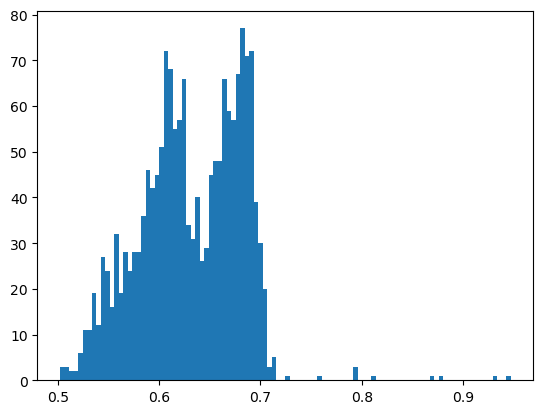

In [75]:

import matplotlib.pyplot as plt
aa = plt.hist((df_==0).sum(axis=1)/df.shape[1], bins=100)

In [34]:
import numpy as np
import pandas as pd
import scanpy as sc

def create_meta_cells(adata, cell_type_col='cell_type', donor_id_col='donor_id', n_cells=15):
    # Initialize lists to store the meta cell data
    meta_cell_data = []
    meta_cell_obs = []

    # Get the raw counts matrix from the AnnData object
    raw_counts = adata.X

    # Get the total number of rows in raw_counts
    n_cells_in_adata = raw_counts.shape[0]

    # Group by cell_type and donor_id
    groups = adata.obs.groupby([cell_type_col, donor_id_col])

    # For each group (cell_type, donor_id combination)
    for (cell_type, donor_id), indices in groups.groups.items():
        # Convert indices to a numpy array of integers
        cell_indices = np.array(list(indices), dtype=int)

        # Filter indices to ensure they are within bounds
        cell_indices = cell_indices[cell_indices < n_cells_in_adata]

        # Process in chunks of 'n_cells' (15)
        for i in range(0, len(cell_indices), n_cells):
            meta_cell_indices = cell_indices[i:i + n_cells]
            
            # Sum the raw counts for the meta cell
            meta_cell_counts = raw_counts[meta_cell_indices].sum(axis=0)

            # Create observation data for the meta cell
            meta_cell_obs.append({
                cell_type_col: cell_type,
                donor_id_col: donor_id
            })
            
            # Append the meta cell data
            meta_cell_data.append(meta_cell_counts)

    # Create a new AnnData object for the meta cells
    meta_cell_data = np.array(meta_cell_data)
    meta_cell_obs = pd.DataFrame(meta_cell_obs)

    meta_adata = sc.AnnData(X=meta_cell_data, obs=meta_cell_obs)

    return meta_adata

# Usage
# Assuming you already have an AnnData object 'adata' with cell_type and donor_id in 'obs'
meta_adata = create_meta_cells(multiomics_rna, cell_type_col='cell_type', donor_id_col='donor_id', n_cells=15)


/tmp/ipykernel_247612/3262953603.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = adata.obs.groupby([cell_type_col, donor_id_col])


ValueError: invalid literal for int() with base 10: 'GTCTTTAGTTAGTGAT-3'

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id'
    var: 'gene_ids', 'interval', 'mean', 'std'
    uns: 'log1p'

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from tqdm import tqdm
from scipy.stats import spearmanr

## VIASH START
par = {
    "multiomics_rna": "resources/grn-benchmark/multiomics_rna.h5ad",
    "tf_all": "resources_test/prior/tf_all.csv",
    "corr_method": "spearman"
}
## VIASH END
print('Read data')
multiomics_rna = ad.read_h5ad(par["multiomics_rna"])
gene_names = multiomics_rna.var_names.to_numpy()
tf_all = np.loadtxt(par['tf_all'], dtype=str)
tf_all = np.intersect1d(tf_all, gene_names)
groups = multiomics_rna.obs.cell_type
print('Noramlize data')
sc.pp.normalize_total(multiomics_rna)
sc.pp.log1p(multiomics_rna)
sc.pp.scale(multiomics_rna)

Read data
Noramlize data


In [2]:
X = multiomics_rna.X
for group in tqdm(np.unique(groups), desc="Processing groups"):
    mask_group = groups == group
    X_sub = X[mask_group, :]
    # stds = np.std(X_sub, axis=0)
    # mask_g = stds != 0
    # stds = stds[mask_g]
    # X_sub = X_sub[:, mask_g]
    # g_names = gene_names[mask_g]
    
    # grn = X_sub.T.dot(X_sub)/np.std(X_sub, axis=0)
    grn = np.corrcoef(X_sub, rowvar=False)
    # grn = np.nan_to_num(grn, nan=0.0, posinf=0.0, neginf=0.0)
    print(grn)
    aa
    # grn = X_sub.T.dot(X_sub)
    # grn = grn/stds
grn

Processing groups:   0%|          | 0/4 [00:00<?, ?it/s]/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Processing groups:   0%|          | 0/4 [00:12<?, ?it/s]

[[ 1.         -0.00363488         nan ... -0.00492481 -0.00260112
  -0.00161067]
 [-0.00363488  1.                 nan ... -0.00787326 -0.0041584
  -0.00257496]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.00492481 -0.00787326         nan ...  1.         -0.00198653
  -0.00348876]
 [-0.00260112 -0.0041584          nan ... -0.00198653  1.
  -0.00184265]
 [-0.00161067 -0.00257496         nan ... -0.00348876 -0.00184265
   1.        ]]


NameError: name 'aa' is not defined

In [34]:
from scipy.stats import pearsonr

def create_corr_net(X: np.ndarray, groups: np.ndarray, method="pearson"):
    grns = []
    for group in tqdm(np.unique(groups), desc="Processing groups"):
        mask_group = groups == group
        X_sub = X[mask_group, :]
        stds = np.std(X_sub, axis=0)
        mask_g = stds != 0
        stds = stds[mask_g]
        X_sub = X_sub[:, mask_g]
        g_names = gene_names[mask_g]
        if method == "pearson":
            # grn = np.corrcoef(X_sub.T)
            grn = X_sub.T.dot(X_sub)
            grn = grn/stds

        elif method == "spearman":
            grn = spearmanr(X_sub).statistic

        grns.append(grn)
    return np.mean(grns, axis=0)
net = create_corr_net(multiomics_rna.X, groups, par['corr_method'])

Processing groups:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_202122/3789168729.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grn = spearmanr(X_sub).statistic
Processing groups:   0%|          | 0/4 [00:00<?, ?it/s]

nan


NameError: name 'aa' is not defined

In [ ]:


print('Read data')


print('Create corr net')

net = pd.DataFrame(net, index=gene_names, columns=gene_names)

if par['causal']:
    net = net[tf_all]
else:
    net = net.sample(len(tf_all), axis=1, random_state=par['seed'])
    
net = net.reset_index().melt(id_vars='index', var_name='source', value_name='weight')
net.rename(columns={'index': 'target'}, inplace=True)


print('Output GRN')
net.to_csv(par['prediction'])


# Sinlge omics

In [ ]:
!bash scripts/run_benchmark_single_omics.sh

In [131]:
!aws s3 sync s3://openproblems-data/resources_test/grn/results/single_omics_inference rsesources/results/single_omics_inference

download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/state.yaml to rsesources/results/single_omics_inference/state.yaml
download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/trace.txt to rsesources/results/single_omics_inference/trace.txt
download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/scores.yaml to rsesources/results/single_omics_inference/scores.yaml
download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/ridge.ennet.ennet.prediction.csv to rsesources/results/single_omics_inference/ridge.ennet.ennet.prediction.csv
download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/ridge.pidc.pidc.prediction.csv to rsesources/results/single_omics_inference/ridge.pidc.pidc.prediction.csv
download: s3://openproblems-data/resources_test/grn/results/single_omics_inference/ridge.tigress.tigress.prediction.csv to rsesources/results/single_omics_inference/r

In [116]:
!aws s3 sync s3://openproblems-data/resources/grn/results/grn_evaluation_all_ridge resources/results/grn_evaluation_all_ridge

download: s3://openproblems-data/resources/grn/results/grn_evaluation_all_ridge/scores.yaml to resources/results/grn_evaluation_all_ridge/scores.yaml
download: s3://openproblems-data/resources/grn/results/grn_evaluation_all_ridge/metric_configs.yaml to resources/results/grn_evaluation_all_ridge/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/grn_evaluation_all_ridge/trace.txt to resources/results/grn_evaluation_all_ridge/trace.txt


In [130]:

models_all = ['negative_control', 'baseline_pearson', 
              'baseline_pearson_causal', 'baseline_pearson_causal_celltype', 
              'baseline_pearson_causal_metacell', 'positive_control', 'collectri','granie', 'figr', 'celloracle', 
              'scglue', 'scenicplus', 'portia','ppcor', 'grnboost2', 'genie3']

def extract_data(data, reg='reg1', dataset_id='scgen_pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg
import yaml
import pandas as pd
base_folder = 'resources/results/grn_evaluation_all_ridge/'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)
df_reg1 = extract_data(data, reg='reg1').reindex(models_all).drop(columns=['Mean'])
df_reg2 = extract_data(data, reg='reg2').reindex(models_all).drop(columns=['Mean'])

# df_reg1 = extract_data(data, reg='reg1').drop(columns=['Mean'])
# df_reg2 = extract_data(data, reg='reg2').drop(columns=['Mean'])
df_all = pd.concat([df_reg1,df_reg2], axis=1).fillna(0)
df_all[df_all<0]=0
df_all_n = (df_all-df_all.min(axis=0))/(df_all.max(axis=0)-df_all.min(axis=0))
df_all['Rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_all.style.background_gradient()

,ex(False)_tf(-1),ex(True)_tf(-1),static-theta-0.0,static-theta-0.5,Rank
negative_control,0.000000,0.000000,0.000000,0.000000,16
baseline_pearson,0.007913,0.062031,0.437762,0.503891,13
baseline_pearson_causal,0.168682,0.270138,0.393565,0.530812,8
baseline_pearson_causal_celltype,0.136589,0.223640,0.546990,0.554080,7
baseline_pearson_causal_metacell,0.065961,0.113844,0.465854,0.524898,11
positive_control,0.231826,0.505384,0.631997,0.625582,3
collectri,0.000000,0.000000,0.489316,0.514896,14
granie,0.108554,0.209125,0.356784,0.526008,10
figr,0.154044,0.220225,0.680781,0.565727,6
celloracle,0.171687,0.235811,0.432617,0.536534,9
